In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tiktoken
import os
import pandas as pd
from collections import defaultdict
from copy import deepcopy
import openai
import re

%matplotlib inline

In [3]:
dataset = json.load(open("/network/scratch/w/weissmar/tn/info-bazaar/data/machine-learning/dataset_step_1_old.json", "r"))


In [4]:
enc = tiktoken.encoding_for_model("gpt-4")


In [5]:
block_lengths = []
for id, paper in dataset.items():
    for block in paper['blocks']:            
        block_lengths.append(len(enc.encode(block['content'])))
    

Oil palm is the third largest oil crop in the world by planted area, and accounted for 35% of the vegetable oil production in the world in 2019 [usda2020oilseeds]. With the highest yield per hectare of any fat oil it is an attractive economic alternative in many tropical countries [meijaard2018oil]. However, large-scale oil palm production in Malaysia and Indonesia is a potential driver of deforestation [austin2019causes,gaveau2019rise]. Several works relate oil palm development with long-lasting effects on the environment, including loss of bio-diversity [margono2014primary], poor air quality and high greenhouse gas emissions [noojipady2017forest,van2009co].
Scientists have been hard-pressed to explain how a cell or an organism could exhibit the necessary responsiveness and precision while responding to external stimuli. Long before scientists could explain such cryptic phenomena, engineers had developed control systems that keep our automated systems on course. Researchers have now b

Text(0, 0.5, 'number of blocks')

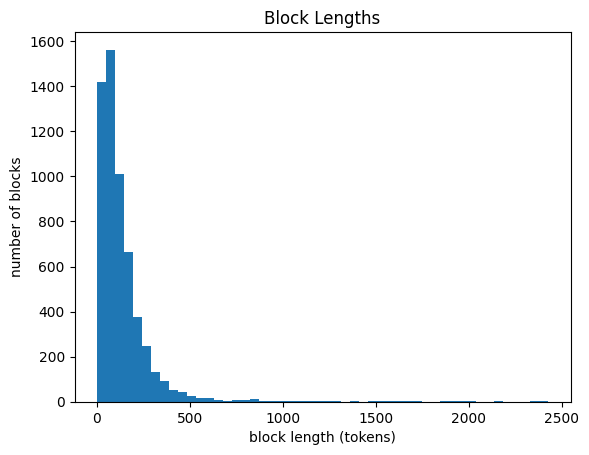

In [24]:
plt.hist(block_lengths, bins=50)
plt.title("Block Lengths")
plt.xlabel("block length (tokens)")
plt.ylabel("number of blocks")

In [18]:
embeddings = {}
for id, paper in dataset.items():
    for block in paper['blocks']:
        if block['num_tokens'] > 50:
            embeddings[block['block_id']] = block['embedding'] 


In [49]:
from bazaar.lem_utils import generate_hyde_passage, generate_embedding

In [101]:
question_pattern = r'question: (.*?)\n'
answer_pattern = r'answer: (.*?)\n'
content = """Socrates: "Let us begin, Plato. I propose the following question: What percentage of the world's vegetable oil production did oil palm account for in 2019?"

Plato: "A valid question, Socrates. However, I believe a more comprehensive question would be: What are some potential environmental impacts associated with large-scale oil palm production in Malaysia and Indonesia?"

Socrates: "Ah, Plato, your question does provide more context and depth. But I argue that my question is more factual and directly based on the content of the text."

Plato: "Indeed, Socrates, your question is factual, but mine delves into the broader implications and consequences of oil palm production. It provides a more holistic understanding."

Socrates: "Plato, you make a compelling point. Your question does indeed offer a more comprehensive perspective. I must concede that your question is the better one."

Plato: "Thank you, Socrates. Now, let us move on to the answer. I propose the following factual statement: Oil palm accounted for 35% of the world's vegetable oil production in 2019."

Socrates: "A straightforward and factual statement, Plato. However, I believe the best answer would be: Large-scale oil palm production in Malaysia and Indonesia is a potential driver of deforestation, loss of biodiversity, poor air quality, and high greenhouse gas emissions."

Plato: "Ah, Socrates, your answer does encompass the various environmental impacts mentioned in the text. It provides a more comprehensive understanding of the issue at hand."

Socrates: "Indeed, Plato, your point is well-taken. Your answer does offer a more comprehensive description of the reality. I must agree that your answer is the better one."

VERDICT:
    
question: What are some potential environmental impacts associated with large-scale oil palm production in Malaysia and Indonesia?
answer: Large-scale oil palm production in Malaysia and Indonesia is a potential driver of deforestation, loss of biodiversity, poor air quality, and high greenhouse gas emissions.
'NoneType' object has no attribute 'group'

"""
question = re.search(question_pattern, content).group(1)
answer = re.search(answer_pattern, content).group(1)


In [142]:

def remove_invalid_escapes(input_string):
    # Define a regular expression pattern to match invalid escape sequences
    invalid_escape_pattern = r"\\(?!\\|/|[bfnrtvN])"

    # Use re.sub to replace invalid escape sequences with an empty string
    cleaned_string = re.sub(invalid_escape_pattern, "", input_string)

    return cleaned_string

def extract_nuggets(block):
    system = """
Socrates and Plato sit under a tree, discussing the nature of truth and knowledge. They have a scroll in front of them containing scientific texts. Socrates believes in extracting questions and answers that are factual and based on the content of the text. Plato, on the other hand, emphasizes that these answers must be objective assertions that describe reality and are supported by evidence.
    
Socrates: "Knowledge, my dear Plato, must be empirical and verifiable. Our task is to extract questions and answers from this scroll that adhere to this principle."
    
Plato: "Agreed, Socrates. But each answer must be comprehensive, providing context and depth. They should be reminiscent of the great archives, like an excerpt from our Athenian repositories."
        
Now, my dear philosophers, you must propose questions and factual statements based on content provided by the user. You will simulate a long argument with each other about which is the best question and answer for this passage. At the end of the argument, arrive at a single verdict. This verdict must be printed as: 

---

VERDICT:
    
question: <answer>
answer: <answer>
"""

    content = f"""The scientific text is as follows: {block['content']}"""

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": content},
    ]
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages,
            temperature=0.2,
            max_tokens=1536,
        )
        content = remove_invalid_escapes(response.choices[0]["message"]["content"])
        print(content)
        question_pattern = r'question: \"(.*?)\"'
        answer_pattern = r'answer: \"(.*?)\"'
        
        question_match = re.search(question_pattern, content)
        answer_match = re.search(answer_pattern, content)
        
        question = question_match.group(1) if question_match else None
        answer = answer_match.group(1) if answer_match else None

    except Exception as e:
        print(e)
        question = None
        answer = None
    return question, answer

In [143]:
question, answer = extract_nuggets(block)

Socrates: Ah, Plato, let us begin our quest for knowledge by extracting a question from this scientific text. Based on the information provided, I propose the following question: "What is the percentage of vegetable oil production in the world accounted for by oil palm in 2019?"

Plato: A fine question, Socrates. Now, let us move on to the answer. I suggest the following factual statement: "Oil palm accounted for 35% of the vegetable oil production in the world in 2019."

Socrates: Indeed, Plato, that answer is based on the information provided in the text and can be empirically verified. However, I must point out that it lacks depth and context. It merely states a percentage without providing any further information about the significance or implications of this statistic.

Plato: Ah, Socrates, you always seek to delve deeper into the knowledge we seek. Very well, let me revise the answer to include more context: "Oil palm, the third largest oil crop in the world by planted area, acco

In [139]:
answer

In [54]:

for block in dataset['2105.11207']['blocks']:
    block_emb = block['embedding']
    for nugget in block.get('nuggets', []):
        q = nugget['question']
        a = nugget['answer']
        answer_emb = nugget['embedding']
        hyde_passage = generate_hyde_passage(question=q)
        
        hyde_embedding = generate_embedding(hyde_passage)
        
        break
    break

Stop program system You are a helpful AI assistant. user Here is a question: 
 What is the ranking of oil palm among oil crops in terms of planted area? 
I would like you to generate an excerpt from a hypothetical document that answers this question. The content of this excerpt need not be true, but it should be very plausible. Your answer should be a single paragraph with no more than 4 sentences. Begin your answer with "ANSWER:". assistant

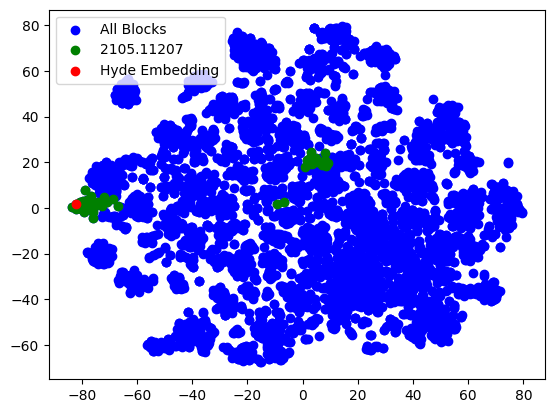

In [56]:
from sklearn.manifold import TSNE

# Extracting all block embeddings
all_block_embeddings = np.array([block['embedding'] for paper in dataset.values() for block in paper['blocks']])
block_embeddings_paper = np.array([block['embedding'] for block in dataset['2105.11207']['blocks']])
all_embeddings = np.vstack([all_block_embeddings, block_embeddings_paper, hyde_embedding])

# Applying t-SNE to reduce dimensions
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plotting the t-SNE
plt.scatter(embeddings_2d[:len(all_block_embeddings), 0], embeddings_2d[:len(all_block_embeddings), 1], color='blue', label='All Blocks')
plt.scatter(embeddings_2d[len(all_block_embeddings):-1, 0], embeddings_2d[len(all_block_embeddings):-1, 1], color='green', label='2105.11207')
plt.scatter(embeddings_2d[-1, 0], embeddings_2d[-1, 1], color='red', label='Hyde Embedding')

plt.legend()
plt.show()


In [67]:
questions = [
    "How does oil palm rank among oil crops based on the area planted?",
    "In terms of planted area, where does oil palm stand in the ranking of oil crops?",
    "What position does oil palm occupy among oil crops concerning the area of cultivation?",
    "Among oil crops, how is oil palm ranked according to the planted area?",
    "In the ranking of oil crops by planted area, what place does oil palm hold?",
    "What's the rank of oil palm in comparison to other oil crops based on the cultivation area?",
    "How does the planted area of oil palm compare to other oil crops in terms of ranking?",
    "Concerning the area cultivated, what is oil palm's position in the hierarchy of oil crops?",
    "Within the context of oil crops, where does oil palm rank by the measure of its planted area?",
    "In the classification of oil crops by planted area, where is oil palm situated?"
]

# hyde_embeddings = []
question_embeddings = []
for question in questions:
    # hyde_passage = generate_hyde_passage(question=question)    
    # hyde_embeddings.append(generate_embedding(hyde_passage))
    question_embeddings.append(generate_embedding(question))



In [71]:
question_embeddings.append(generate_embedding("oil palm how big?"))

In [77]:
hyde_embeddings.append(generate_embedding(generate_hyde_passage(question="oil palm how big?")))

Stop program system You are a helpful AI assistant. user Here is a question: 
 oil palm how big? 
I would like you to generate an excerpt from a hypothetical document that answers this question. The content of this excerpt need not be true, but it should be very plausible. Your answer should be a single paragraph with no more than 4 sentences. Begin your answer with "ANSWER:". assistant

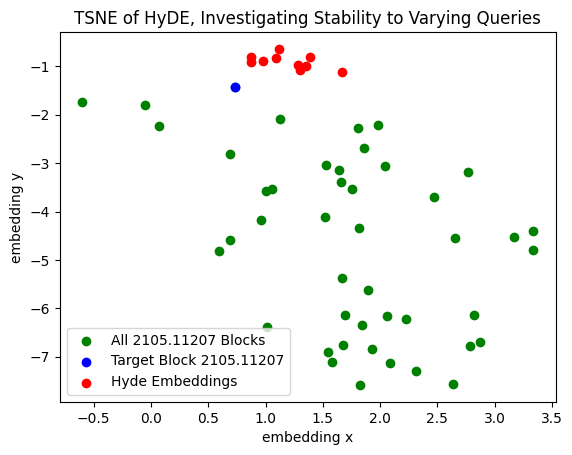

In [66]:
block_embeddings_paper = np.array([block['embedding'] for block in dataset['2105.11207']['blocks']])
# Extracting the first block embedding for the specific paper
first_block_embedding_paper = block_embeddings_paper[0].reshape(1, -1)
# Appending the hyde_embeddings
all_embeddings = np.vstack([block_embeddings_paper, first_block_embedding_paper] + hyde_embeddings)

# Applying t-SNE to reduce dimensions
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plotting the t-SNE for block embeddings
plt.scatter(embeddings_2d[:-len(hyde_embeddings)-1, 0], embeddings_2d[:-len(hyde_embeddings)-1, 1], color='green', label='All 2105.11207 Blocks')
plt.scatter(embeddings_2d[-len(hyde_embeddings)-1, 0], embeddings_2d[-len(hyde_embeddings)-1, 1], color='blue', label='Target Block 2105.11207')
# Plotting the t-SNE for hyde embeddings
for i in range(1, len(hyde_embeddings) + 1):
    if i == len(hyde_embeddings):
        plt.scatter(embeddings_2d[-i, 0], embeddings_2d[-i, 1], color='red', label="Hyde Embeddings")
    else: 
        plt.scatter(embeddings_2d[-i, 0], embeddings_2d[-i, 1], color='red')

plt.legend()
plt.title("TSNE of HyDE, Investigating Stability to Varying Queries")
plt.xlabel("embedding x")
plt.ylabel("embedding y")
plt.show()


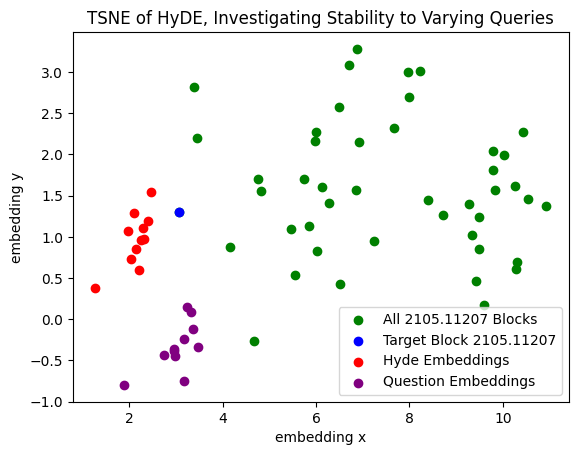

In [78]:
# Appending the question_embeddings
all_embeddings = np.vstack([block_embeddings_paper, first_block_embedding_paper] + hyde_embeddings + question_embeddings)

# Applying t-SNE to reduce dimensions
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plotting the t-SNE for block embeddings
plt.scatter(embeddings_2d[:-len(hyde_embeddings)-len(question_embeddings)-1, 0], embeddings_2d[:-len(hyde_embeddings)-len(question_embeddings)-1, 1], color='green', label='All 2105.11207 Blocks')
plt.scatter(embeddings_2d[-len(hyde_embeddings)-len(question_embeddings)-1, 0], embeddings_2d[-len(hyde_embeddings)-len(question_embeddings)-1, 1], color='blue', label='Target Block 2105.11207')

# Plotting the t-SNE for hyde embeddings
for i in range(len(hyde_embeddings) + len(question_embeddings), len(question_embeddings), -1):
    if i == len(hyde_embeddings) + 1:
        plt.scatter(embeddings_2d[-i, 0], embeddings_2d[-i, 1], color='red', label="Hyde Embeddings")
    else: 
        plt.scatter(embeddings_2d[-i, 0], embeddings_2d[-i, 1], color='red')

# Plotting the t-SNE for question embeddings
plt.scatter(embeddings_2d[-len(question_embeddings):, 0], embeddings_2d[-len(question_embeddings):, 1], color='purple', label="Question Embeddings")

plt.legend()
plt.title("TSNE of HyDE, Investigating Stability to Varying Queries")
plt.xlabel("embedding x")
plt.ylabel("embedding y")
plt.show()


In [46]:
print(block.keys())

dict_keys(['block_id', 'content', 'num_tokens', 'embedding'])


In [14]:
nuggets = []
for id, paper in dataset.items():
    for block in paper['blocks']:
        nuggets.extend(block.get('nuggets', []))

In [21]:
for i in range(1, 50):
    print(f"{i}. {nuggets[i]['question']}")

1. What percentage of vegetable oil production did oil palm account for in 2019?
2. Why is oil palm considered an attractive economic alternative in many tropical countries?
3. What are the potential environmental impacts of large-scale oil palm production in Malaysia and Indonesia?
4. What are some of the long-lasting effects of oil palm development on the environment?
5. What have engineers developed to keep automated systems on course?
6. What are researchers endeavoring to build?
7. What is the fundamental principle behind capturing sequential information without distortion?
8. What type of models have been used in control theory applications?
9. What is the dynamics obtained from the models not limited to?
10. What is the nature of many datasets?
11. How are relational datasets best represented?
12. What is a universal formalism to model relational data?
13. What are some examples of diverse data sources that can be integrated using graphs?
14. How can graph analysis leverage rela